In [1]:
from sqlalchemy import create_engine,text
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
db_user = ""
db_password = ""
db_host = "" 
db_port = ""  
db_name = ""

In [3]:
connection = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(connection)

In [4]:
ACE = '08|037|025|000%'
nome_ACE = 'Dozza'

In [5]:
query_toid = text("SELECT DATE(datefrom) AS date, SUM(datavalue) AS datavalue FROM movements WHERE toid LIKE '" + ACE + "' GROUP BY date ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_toid, connection, chunksize=1000) 
        df_toid = pd.concat(chunks, ignore_index=True) 
    print(df_toid)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  datavalue
0   2019-08-01      10241
1   2019-08-02       9752
2   2019-08-03       9188
3   2019-08-04       7757
4   2019-08-05       8431
..         ...        ...
56  2019-09-26      10703
57  2019-09-27       9880
58  2019-09-28      10000
59  2019-09-29       9900
60  2019-09-30      10096

[61 rows x 2 columns]


In [6]:
query_layerid = text("SELECT DATE(datefrom) AS date, SUM(datavalue) AS datavalue FROM movements WHERE layerid LIKE '"+ ACE +"' GROUP BY date ORDER BY date;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_layerid, connection, chunksize=1000) 
        df_layerid = pd.concat(chunks, ignore_index=True) 
    print(df_layerid)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          date  datavalue
0   2019-08-01       9502
1   2019-08-02       9219
2   2019-08-03       9720
3   2019-08-04       7329
4   2019-08-05       8667
..         ...        ...
56  2019-09-26       9620
57  2019-09-27      10370
58  2019-09-28      10513
59  2019-09-29      10295
60  2019-09-30      10151

[61 rows x 2 columns]


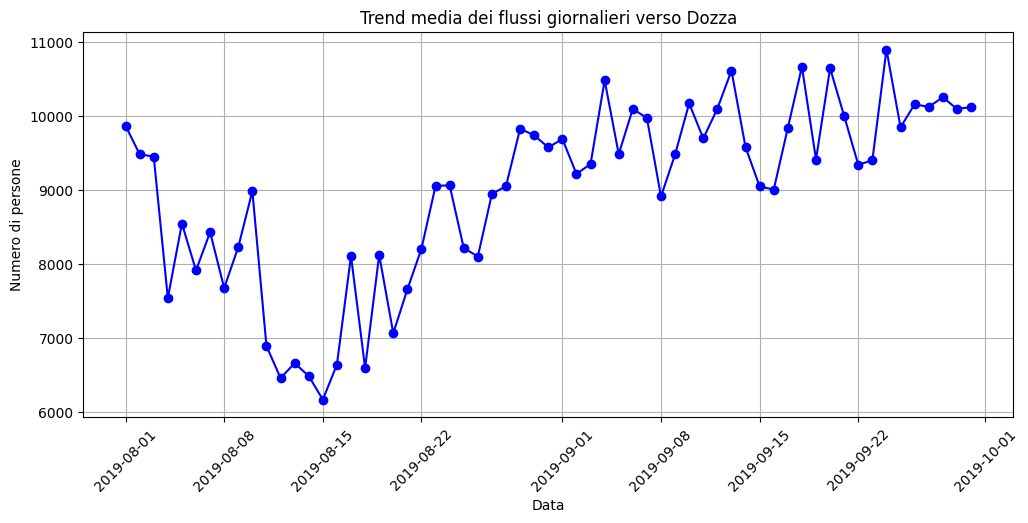

In [7]:
df_avg = pd.DataFrame()
df_avg['date'] = df_layerid['date']
df_avg["datavalue"] = (df_layerid["datavalue"] + df_toid["datavalue"]) / 2
plt.figure(figsize=(12, 5))
plt.plot(df_avg["date"], df_avg["datavalue"], marker='o', linestyle='-', color='b')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title("Trend media dei flussi giornalieri verso " + nome_ACE)
plt.xticks(rotation=45)
plt.grid()
plt.show()

Polinomiale (senza features)

In [9]:
df_avg["date"] = pd.to_datetime(df_avg["date"], format="%Y-%m-%d")
df_avg['date_ordinal'] = df_avg['date'].map(pd.Timestamp.toordinal)

MAD: 455.65
R² Score: 0.7794
MAPE: 5.34%


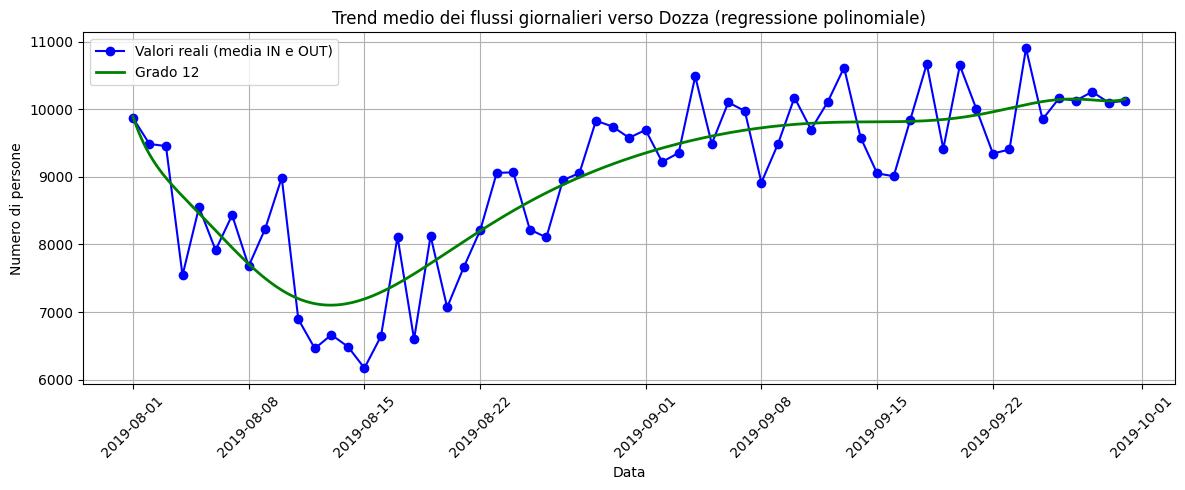

In [10]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import Ridge
from datetime import datetime

X = df_avg["date_ordinal"].values.reshape(-1, 1)
y = df_avg["datavalue"].values

# Modello
grado = 12
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=grado),
    Ridge(alpha=1.0)
)

# Fit
model.fit(X, y)

# X_fit con float per lisciare la curva
X_fit = np.linspace(X.min(), X.max(), 300).reshape(-1, 1)
y_fit = model.predict(X_fit)

# Converti X_fit in date leggibili
ordinal_to_unix_offset = datetime(1970, 1, 1).toordinal()
date_fit = pd.to_datetime(X_fit.flatten() - ordinal_to_unix_offset, unit='D', origin='unix')

#metriche
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
y_true = df_avg['datavalue'].values
y_pred = model.predict(X)

mape = np.mean(np.abs((y_true - y_pred) / np.where(y_true == 0, 1e-8, y_true))) * 100
r2 = r2_score(y_true, y_pred)
errors = y_true - y_pred
mad = np.mean(np.abs(errors - np.mean(errors)))

print(f"MAD: {mad:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")
# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_avg['date'], df_avg['datavalue'], marker='o', linestyle='-', color='b', label='Valori reali (media IN e OUT)')
plt.plot(date_fit, y_fit, 'g-', linewidth=2, label=f'Grado {grado}')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title("Trend medio dei flussi giornalieri verso " + nome_ACE + " (regressione polinomiale)")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

Polinomiale con features

In [12]:
df_feat = pd.DataFrame()
df_feat['date'] = df_layerid['date']
df_feat["datavalue"] = (df_layerid["datavalue"] + df_toid["datavalue"]) / 2
df_feat

,date,datavalue
0,2019-08-01,9871.5
1,2019-08-02,9485.5
2,2019-08-03,9454.0
3,2019-08-04,7543.0
4,2019-08-05,8549.0
...,...,...
56,2019-09-26,10161.5
57,2019-09-27,10125.0
58,2019-09-28,10256.5
59,2019-09-29,10097.5


In [13]:
df_feat["date"] = pd.to_datetime(df_feat["date"], format="%Y-%m-%d")
df_feat["weekday"] = df_feat["date"].dt.weekday
df_feat["week"] = df_feat["date"].dt.isocalendar().week - df_feat["date"].dt.isocalendar().week.min()
df_feat["weekend"] = df_feat["weekday"].apply(lambda w: 1 if (w == 5 or w == 6) else 0)
df_feat

,date,datavalue,weekday,week,weekend
0,2019-08-01,9871.5,3,0,0
1,2019-08-02,9485.5,4,0,0
2,2019-08-03,9454.0,5,0,1
3,2019-08-04,7543.0,6,0,1
4,2019-08-05,8549.0,0,1,0
...,...,...,...,...,...
56,2019-09-26,10161.5,3,8,0
57,2019-09-27,10125.0,4,8,0
58,2019-09-28,10256.5,5,8,1
59,2019-09-29,10097.5,6,8,1


In [14]:
query_weather = text("SELECT data, fenomeni FROM weather_data;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_weather, connection, chunksize=1000) 
        df_weather = pd.concat(chunks, ignore_index=True) 
    print(df_weather)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          data            fenomeni
0   2019-08-01                    
1   2019-08-02  pioggia temporale 
2   2019-08-03                    
3   2019-08-04                    
4   2019-08-05                    
..         ...                 ...
56  2019-09-26             nebbia 
57  2019-09-27                    
58  2019-09-28                    
59  2019-09-29                    
60  2019-09-30                    

[61 rows x 2 columns]


In [15]:
query_events = text("SELECT * FROM dozza_eventi;")
try:
    with engine.connect() as connection:
        chunks = pd.read_sql(query_events, connection, chunksize=1000) 
        df_events = pd.concat(chunks, ignore_index=True) 
    print(df_events)
except Exception as e:
    print(f"Errore durante l'esecuzione della query: {e}")

          data  evento
0   2019-08-01       0
1   2019-08-02       0
2   2019-08-03       0
3   2019-08-04       0
4   2019-08-05       0
..         ...     ...
56  2019-09-26       0
57  2019-09-27       0
58  2019-09-28       0
59  2019-09-29       0
60  2019-09-30       0

[61 rows x 2 columns]


In [16]:
from sklearn.preprocessing import LabelEncoder
df_weather["data"] = pd.to_datetime(df_weather["data"])
df_events["data"] = pd.to_datetime(df_events["data"])

df_feat = df_feat.merge(df_weather, left_on ="date", right_on="data", how="left")
df_feat.drop(columns=["data"], inplace=True, errors = "ignore")

df_feat = df_feat.merge(df_events, left_on="date", right_on="data", how="left")
df_feat.drop(columns=["data"], inplace=True, errors = "ignore")

le = LabelEncoder()
df_feat['fenomeni'] = le.fit_transform(df_feat['fenomeni'])
df_feat['fenomeni'] = df_feat['fenomeni'].apply(lambda x: 1 if x > 0 else 0)

df_feat

,date,datavalue,weekday,week,weekend,fenomeni,evento
0,2019-08-01,9871.5,3,0,0,0,0
1,2019-08-02,9485.5,4,0,0,1,0
2,2019-08-03,9454.0,5,0,1,0,0
3,2019-08-04,7543.0,6,0,1,0,0
4,2019-08-05,8549.0,0,1,0,0,0
...,...,...,...,...,...,...,...
56,2019-09-26,10161.5,3,8,0,1,0
57,2019-09-27,10125.0,4,8,0,0,0
58,2019-09-28,10256.5,5,8,1,0,0
59,2019-09-29,10097.5,6,8,1,0,0


Con features:
MAD: 198.28
R² Score: 0.9401
MAPE: 2.23%


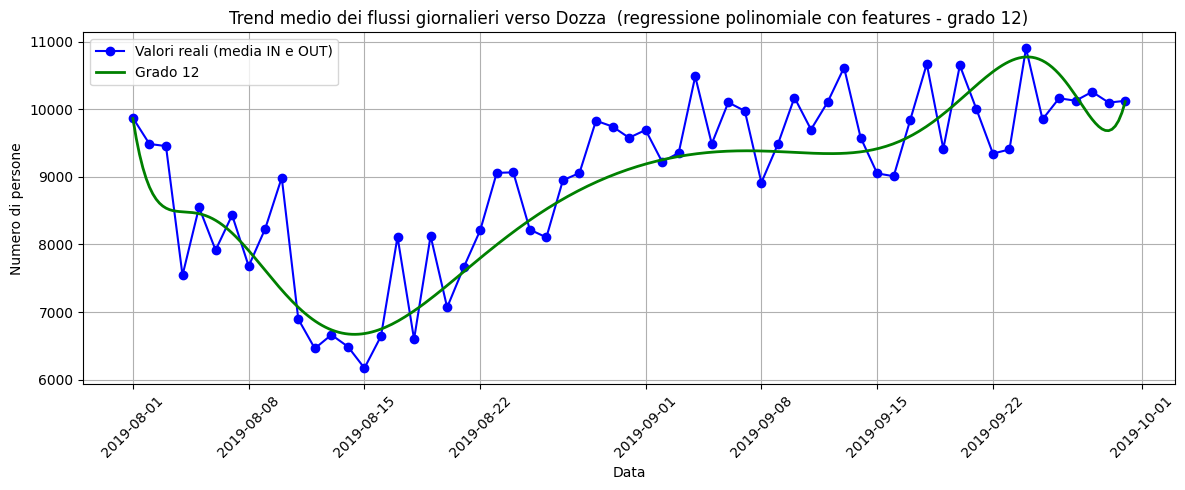

In [17]:
from datetime import datetime, timedelta
df_feat['date_ordinal'] = df_feat['date'].map(pd.Timestamp.toordinal)

Xf = df_feat[["date_ordinal", "weekend", "fenomeni", "evento"]].values
yf = df_feat["datavalue"].values

# Modello
model = make_pipeline(
    StandardScaler(),
    PolynomialFeatures(degree=grado),
    Ridge(alpha=1.0)
)

# Fit
model.fit(Xf, yf)

# Creazione X_fit per variare solo la data (gli altri a 0)
date_range = np.linspace(df_feat['date_ordinal'].min(), df_feat['date_ordinal'].max(), 300)
X_fitf = np.column_stack([date_range, np.zeros((300, 3))])  # weekend, fenomeni, evento = 0
y_fitf = model.predict(X_fitf)

# Converti date ordinali in datetime fluidi
date_fit = [datetime.fromordinal(int(x)) + timedelta(days=x % 1) for x in date_range]

#Metriche
y_truef = df_feat['datavalue'].values
y_predf = model.predict(Xf)

mape = np.mean(np.abs((y_truef - y_predf) / np.where(y_truef == 0, 1e-8, y_truef))) * 100
r2 = r2_score(y_truef, y_predf)
errors = y_truef - y_predf
mad = np.mean(np.abs(errors - np.mean(errors)))

print("Con features:")
print(f"MAD: {mad:.2f}")
print(f"R² Score: {r2:.4f}")
print(f"MAPE: {mape:.2f}%")

# Plot
plt.figure(figsize=(12, 5))
plt.plot(df_feat['date'], df_feat['datavalue'], marker='o', linestyle='-', color='b', label='Valori reali (media IN e OUT)')
plt.plot(date_fit, y_fitf, 'g-', linewidth=2, label=f'Grado {grado}')
plt.xlabel("Data")
plt.ylabel("Numero di persone")
plt.title(f"Trend medio dei flussi giornalieri verso " + nome_ACE + f"  (regressione polinomiale con features - grado {grado})")
plt.xticks(rotation=45)
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()